# Build Qutrit

Since here, we've learn about 1) how to compose a pulse schedule with the `pulse.build` command and 2) did some sweep experiement with the qubit frequency and the amplitude.

By combining all things together, we can access to the higher qubit state - $|2\rangle$ - and can build a pulse schedul to access to that directly. Let's start our new challenge.

## What is the Qutrit?
A qutrit (or quantum trit) is a unit of quantum information that is realized by a 3-level quantum system, that may be in a superposition of three mutually orthogonal quantum states.

A qutrit has three orthonormal basis states or vectors, often denoted $|0\rangle$ $|1\rangle$ and $|2\rangle$  and t
hese are used to describe the qutrit as a superposition state vector in the form of a linear combination of the three orthonormal basis states:

$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle + \gamma |2\rangle$
where the coefficients are complex probability amplitudes, such that the sum of their squares is unity (normalization):

$| \alpha |^2 + | \beta |^2 + | \gamma |^2 = 1$

At this lecture, we will try to build a basic Qutrit gate - X02, X12 by using qiskit pulse.
To build a qutrit gate, we need to learn how to access to the $|2\rangle$ state.

Before code, take a glace on the physical background of the anharmonicity of the transmon Qubit.

### Physics Background (from Qiskit Textbook)

<div class="alert alert-block alert-info">
Description comes from the <a href="https://qiskit.org/textbook/ch-quantum-hardware/accessing_higher_energy_states.html">Accessing Higher Energy States
, Qiskit Textbook</a></div>

We now give some additional background on the physics of transmon qubits, the basis for much of IBM's quantum hardware. These systems contain superconducting circuits composed of a Josephson junction and capacitor. For those unfamiliar with superconducting circuits, see the review [here](https://arxiv.org/pdf/1904.06560.pdf). The Hamiltonian of this system is given by

$$
H = 4 E_C n^2 - E_J \cos(\phi),
$$

where $E_C, E_J$ denote the capacitor and Josephson energies, $n$ is the reduced charge number operator and $\phi$ is the reduced flux across the junction. We work in units with $\hbar=1$.

Transmon qubits are defined in the regime where $\phi$ is small, so we may expand $E_J \cos(\phi)$ in a Taylor series (ignoring constant terms)

$$
E_J \cos(\phi) \approx \frac{1}{2} E_J \phi^2 - \frac{1}{24} E_J \phi^4 + \mathcal{O}(\phi^6).
$$

The quadratic term $\phi^2$ defines the standard harmonic oscillator. Each additional term contributes an anharmonicity.

Using the relations $n \sim (a-a^\dagger), \phi \sim (a+a^\dagger)$ (for raising, lowering operators $a^\dagger, a$), it can be shown that the system resembles a Duffing oscillator with Hamiltonian
$$
H = \omega a^\dagger a + \frac{\alpha}{2} a^\dagger a^\dagger a a,
$$

where $\omega$ gives the $0\rightarrow1$ excitation frequency ($\omega \equiv \omega^{0\rightarrow1}$) and $\alpha$ is the anharmonicity between the $0\rightarrow1$ and $1\rightarrow2$ frequencies ($\alpha \equiv \omega^{1\rightarrow2} - \omega^{0\rightarrow1}$). Drive terms can be added as needed. 

If we choose to specialize to the standard 2-dimensional subspace, we can make $|\alpha|$ sufficiently large or use special control techniques to suppress the higher energy states.


In [1]:
import numpy as np

from qiskit import *
from qiskit.tools.monitor import job_monitor

from qiskit import assemble,pulse,QuantumCircuit,schedule,transpile
from qiskit.pulse.channels import ControlChannel, DriveChannel

from qiskit.circuit import Gate
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.test.mock import FakeArmonk
from qiskit.visualization import plot_histogram

from qiskit.visualization.pulse_v2 import draw, IQXSimple, IQXDebugging,IQXStandard

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

## Access to the |2> state

To use the |2> state, we need one experiment - amplitude sweep to make a x12 pulse. Since we've been optimized the x01 pulse at part2, we will use that here:

In [3]:
with pulse.build(backend=backend, default_alignment='sequential') as x_pulse:
    pulse.play(pulse.Drag(duration=320, amp=0.9116700402723725, sigma=80, beta=-1.0111553175219203), pulse.drive_channel(0))

###  Computing the 1->2 frequency 

The first step in our calibration is to compute the frequency needed to go from the $1\rightarrow2$ state. There are two methods to do this:
1. Do a frequency sweep from the ground state and apply very high power. If the applied power is large enough, two peaks should be observed. One at the $0\rightarrow1$ frequency found in section [1](#discrim01) and one at the $0\rightarrow2$ frequency. The $1\rightarrow2$ frequency can be obtained by taking the difference of the two. Unfortunately, for `ibmq_armonk`, the maximum drive power of $1.0$ is not sufficient to see this transition. Instead, we turn to the second method.
2. Excite the $|1\rangle$ state by applying a $0\rightarrow1$ $\pi$ pulse. Then perform the frequency sweep over excitations of the $|1\rangle$ state. A single peak should be observed at a frequency lower than the $0\rightarrow1$ frequency which corresponds to the $1\rightarrow2$ frequency.

#### 1->2 Frequency Sweep using the sideband method 

We follow the second method described above. To drive the $0\rightarrow 1$ $\pi$ pulse, we require a local oscillator (LO) frequency given by the calibrated $0\rightarrow1$ frequency `cal_qubit_freq` which we've already get at Part2. To sweep the range for the $1\rightarrow2$ frequency, however, we require varying the LO frequency. Unfortunately, the Pulse specification requires a single LO frequency per schedule. 

To resolve this, we set the LO frequency to `cal_qubit_freq` and multiply a sine function onto the $1\rightarrow2$ pulse at `freq-cal_qubit_freq`, where `freq` is the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

This is the general process of the standard `sideband` method, and here, I will show you very simple, but result gurantee method to get the $|1\rangle$ -> $|2\rangle$ frequency. Below is the code.

In [4]:
def build_spec12_pulse_schedule(freq, anharm_guess_GHz):    
    with pulse.build(backend=backend, name="Spec Pulse at %.3f GHz" % (freq+anharm_guess_GHz)) as spec12_schedule:
        with pulse.align_sequential():            
            
            # X Pulse
            pulse.call(x_pulse)
            pulse.set_frequency((freq+anharm_guess_GHz)*GHz, DriveChannel(qubit))
            pulse.call(x_pulse)
            pulse.measure(0)
    
            # WRITE YOUR CODE BETWEEN THESE LINES - END
    return spec12_schedule

The upper code use one frequency set with call x_pulse twice. The simple principle is this: After get the $|1\rangle$ state, slightly change the frequency. This will gurantee us the second x-pulse result will be affected by this factor to find the second transition frequency. Let's how it works.

First, set the frequency sweep list. It is well known that the second frequency is around 300MHz nearby the first transition frequency, so we will use this to get the list.

In [5]:
def get_spec12_freqs(f01, qubit):
    return np.linspace(f01 - spec_range/2, f01 + spec_range/2, num_spec12_freqs)

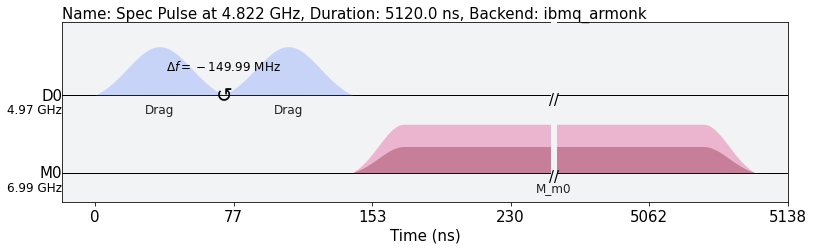

In [6]:
f01 = 4.9716
qubit = 0
spec_range = 0.300 
num_spec12_freqs = 71
GHz = 1.0e9 # Gigahertz


anharmonicity_guess_GHz = -0.3 # your anharmonicity guess
freqs_GHz = get_spec12_freqs(f01, qubit)

# Now vary the sideband frequency for each spec pulse
spec12_scheds = []
for freq in freqs_GHz:
    spec12_scheds.append(build_spec12_pulse_schedule(freq, anharmonicity_guess_GHz))

# Draw spec12 schedule   
draw(spec12_scheds[-1], backend=backend)

In [37]:
backend = provider.get_backend('ibmq_armonk')
#backend = FakeArmonk()
num_shots = 8192

job = backend.run(spec12_scheds, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [8]:
retrieved_job = backend.retrieve_job('617ae4cb6749edcc68018761')

In [10]:
#bring a fitter function from the helper library of the IBM Quantum Challenge 2021 May
from qiskit.ignis.characterization.fitters import IQFitter

class SpecFitter(IQFitter):
    """ Spectroscopy Experiment fitter"""

    def __init__(self, backend_result, xdata, qubits, fit_p0, fit_bounds=None):
        """
            See BaseCalibrationFitter __init__
            fit_p0 is [amp, freq, scale, offset]
        """

        schedule_names = []
        for _, xval in enumerate(xdata):
            schedule_names.append("Spec Pulse at %.3f GH" % xval)

        IQFitter.__init__(self, 'Spec',
                          backend_result, xdata,
                          qubits,
                          lorentzian,
                          fit_p0, fit_bounds,
                          circuit_names=schedule_names,
                          series=['z'])

    def spec_freq(self, qind, series='z'):
        return self._params[series][qind][1]

    def plot(self, qind, series='z', ax=None, show_plot=False):
        """
        Plot the data and fit
        Args:
            qind (int): qubit index
            series (str): data series to plot (for rabi data always '0')
            ax (Axes): matploblib axes (if none created)
            show_plot (bool): do plot.show
        Returns:
            Axes: Plot axes
        """

        fig, ax = plt.subplots(1, 1, figsize=(8,5))

        ax = IQFitter.plot(self, qind, series, ax,
                           show_plot)

        ax.set_ylabel("IQ Signal (au)")
        ax.set_xlabel("Drive Frequency")

        return ax
def lorentzian(x, A, q_freq, B, C):
    return (A/np.pi)*(B/((x-q_freq)**2 + B**2)) + C

Spec12 frequency is 4.622716 GHz


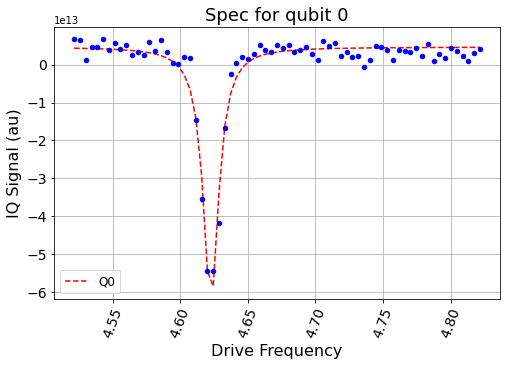

In [11]:
import matplotlib.pyplot as plt

amp_guess = 2e7
f12_guess = f01 - 0.3
B = .1
C = 0
fit_guess = [-amp_guess, f12_guess, B, C]

fit = SpecFitter(retrieved_job.result(), freqs_GHz+anharmonicity_guess_GHz, qubits=[0], fit_p0=fit_guess)
fit.plot(0, series='z')
f12 = fit.spec_freq(0, series='z')
print("Spec12 frequency is %.6f GHz" % f12)

We can clearly see the second transition frequency -`4.622716`. With this value let's plot bunch of $|0\rangle$, $|1\rangle$ and $|2\rangle$ to check.


In [13]:
# Create three schedules

# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    pulse.measure(0)


# Excited state schedule, X01
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc1_schedule:
    pulse.call(x_pulse)
    pulse.measure(0)
    
# 2nd excited state schedule, X02
with pulse.build(backend=backend, default_alignment='sequential', name='2nd excited state') as exc2_schedule:
    pulse.call(x_pulse)
    pulse.set_frequency((4.622716)*GHz, DriveChannel(0))
    pulse.call(x_pulse)
    pulse.measure(0)

In [53]:
exc2_schedule
num_shots = 8192

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


#backend = FakeArmonk()
job = backend.run([gnd_schedule, exc1_schedule, exc2_schedule], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

ibmqfactory.load_account:WARNING:2021-10-29 03:23:10,952: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


In [14]:
retrieved_job = backend.retrieve_job('617aea98173a3ffc14febfed')

In [15]:
gnd_exc_results = retrieved_job.result()

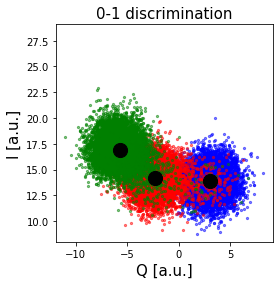

In [16]:
scale_factor = 1e-14

gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc1_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor
exc2_results = gnd_exc_results.get_memory(2)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc1_results), np.imag(exc1_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
plt.scatter(np.real(exc2_results), np.imag(exc2_results), 
                s=5, cmap='viridis', c='green', alpha=0.5, label='state_2')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc1 = np.mean(exc1_results)
mean_exc2 = np.mean(exc2_results)

plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc1), np.imag(mean_exc1), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')
plt.scatter(np.real(mean_exc2), np.imag(mean_exc2), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

To see more clearly, let's plot each seperately.

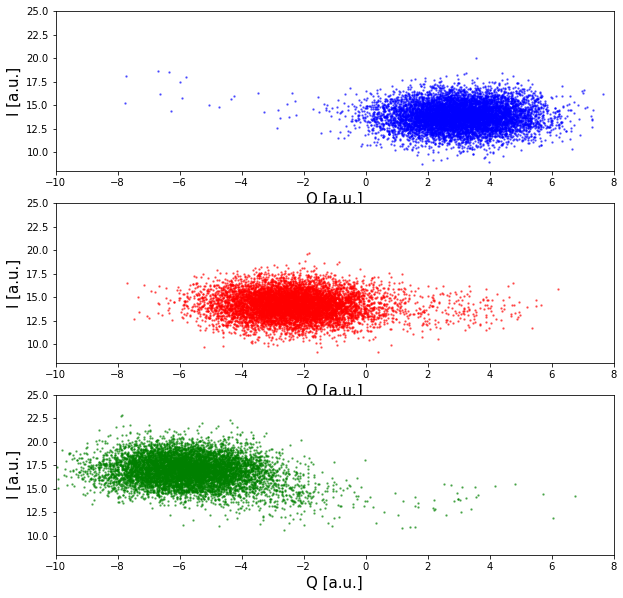

In [20]:
fig, ax = plt.subplots(3, figsize=(10, 10))
ax[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=2, cmap='viridis', c='blue', alpha=0.5, label='state_0')
ax[0].set_xlabel('Q [a.u.]', fontsize=15)
ax[0].set_ylabel('I [a.u.]', fontsize=15)
ax[0].set(xlim=(-10, 8), ylim=(8, 25))


ax[1].scatter(np.real(exc1_results), np.imag(exc1_results), 
                s=2, cmap='viridis', c='red', alpha=0.5, label='state_1')
ax[1].set_xlabel('Q [a.u.]', fontsize=15)
ax[1].set_ylabel('I [a.u.]', fontsize=15)
ax[1].set(xlim=(-10, 8), ylim=(8, 25))

ax[2].scatter(np.real(exc2_results), np.imag(exc2_results), 
                s=2, cmap='viridis', c='green', alpha=0.5, label='state_1')
ax[2].set_xlabel('Q [a.u.]', fontsize=15)
ax[2].set_ylabel('I [a.u.]', fontsize=15)
ax[2].set(xlim=(-10, 8), ylim=(8, 25))
plt.show()

You can see huge cross-over btw the $|1\rangle$ and $|2\rangle$. To reduce the cross area, we can consider to change second x_pulse - frequency/ amplitude / phase, etc. Or you can define a ML driven discriminator to seperate states, and here I brought the method which introduced at the Qiskit Textbook. 

I will leave more optimizing process for yourself. If you are interested in using pulse, try to do more

The process for building the higher state discriminator of the **Qiskit Textbook** is as follows:

1. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.
2. Separate the data from each schedule into training and testing sets and construct an LDA model for discrimination.

In [22]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [23]:
# Create IQ vector (split real, imag parts) with the value we've already got

zero_data_reshaped = reshape_complex_vec(gnd_results)
one_data_reshaped = reshape_complex_vec(exc1_results)  
two_data_reshaped = reshape_complex_vec(exc2_results)  


IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
#print(IQ_012_data.shape) # verify IQ data shape

In [25]:
NUM_SHOTS = 8192

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

In [26]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

After training, let's try to do single prediction with the i=20000th data.

In [72]:
LDA_012.predict((([IQ_012_data[20000]])))[0]

2.0

In [73]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.9319661458333334


In [74]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    
    zero_data = gnd_results
    one_data = exc1_results
    two_data = exc2_results
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [75]:
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

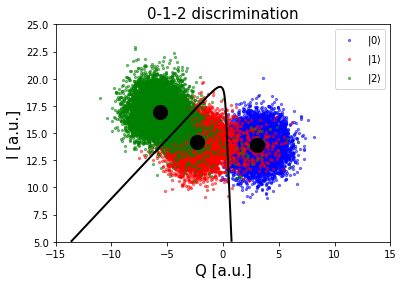

In [76]:
x_min = -15
x_max = 15
y_min = 5
y_max = 25


IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

With this Discriminator, let's plot the count result of each state.

In [88]:
def LDA_count(reshaped_data):
    results = dict()
    count_0 = 0
    count_1 = 0
    count_2 = 0
    for i in range(8192):
        measure = LDA_012.predict((([reshaped_data[i]])))[0]

        if measure == 0:
            count_0 = count_0 + 1
        elif measure == 1:
            count_1 = count_1 + 1
        elif measure == 2:
            count_2 = count_2 + 1
    results['0'] = count_0
    results['1'] = count_1
    results['2'] = count_2
    
    return results

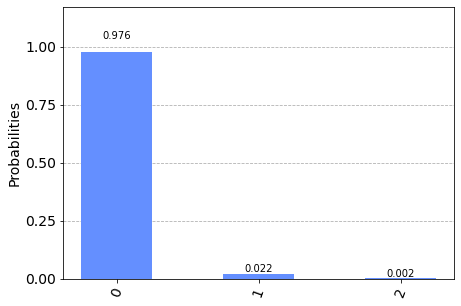

In [89]:
plot_histogram(LDA_count(zero_data_reshaped))

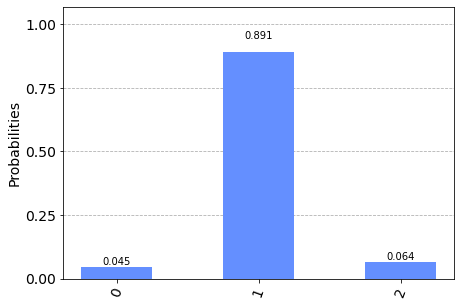

In [90]:
plot_histogram(LDA_count(one_data_reshaped))

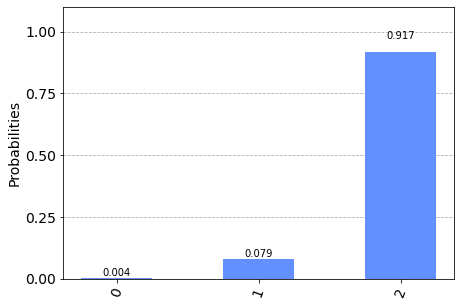

In [91]:
plot_histogram(LDA_count(two_data_reshaped))

Now, we are suceed in building a discriminator, Let's do simple Qutrit experiment - to build a H02. To achieve equi

In [ ]:
with pulse.build(backend=backend, default_alignment='sequential') as new_x_pulse:
    pulse.play(pulse.Drag(duration=320, amp=0.7116700402723725, sigma=80, beta=-1.0111553175219203), pulse.drive_channel(0))

In [78]:
# 2nd excited state schedule, X02
with pulse.build(backend=backend, default_alignment='sequential', name='2nd excited state') as h02_schedule:
    pulse.call(new_x_pulse)
    pulse.set_frequency((4.622716)*GHz, DriveChannel(0))
    pulse.play(pulse.Drag(duration=320, amp=0.9116700402723725, sigma=80, beta=-1.0111553175219203), pulse.drive_channel(0))
    pulse.measure(0)

In [ ]:
num_shots = 8192

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

#backend = FakeArmonk()
h02_test_job = backend.run(h02_schedule, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(h02_test_job)


In [ ]:
#617af49ddd41866badaedcd7
#result = job.result()
retrieved_job = backend.retrieve_job('617b5b0c6749edea330189e4')
job_monitor(retrieved_job)


Job Status: job is queued (13)

In [ ]:
#import result and post process
retrieved_job_results = retrieved_job.result()
h02_results = retrieved_job_results.get_memory(0)[:, qubit]*scale_factor
h02_reshaped = reshape_complex_vec(h02_results)  


In [ ]:
plot_histogram(LDA_count(h02_reshaped))